# One Way ANOVA Model using JAGS

In [1]:
data("PlantGrowth")

In [2]:
?PlantGrowth

PlantGrowth              package:datasets              R Documentation

_R_e_s_u_l_t_s _f_r_o_m _a_n _E_x_p_e_r_i_m_e_n_t _o_n _P_l_a_n_t _G_r_o_w_t_h

_D_e_s_c_r_i_p_t_i_o_n:

     Results from an experiment to compare yields (as measured by dried
     weight of plants) obtained under a control and two different
     treatment conditions.

_U_s_a_g_e:

     PlantGrowth
     
_F_o_r_m_a_t:

     A data frame of 30 cases on 2 variables.

       [, 1]  weight  numeric 
       [, 2]  group   factor  
      
     The levels of ‘group’ are ‘ctrl’, ‘trt1’, and ‘trt2’.

_S_o_u_r_c_e:

     Dobson, A. J. (1983) _An Introduction to Statistical Modelling_.
     London: Chapman and Hall.

_E_x_a_m_p_l_e_s:

     ## One factor ANOVA example from Dobson's book, cf. Table 7.4:
     require(stats); require(graphics)
     boxplot(weight ~ group, data = PlantGrowth, main = "PlantGrowth data",
             ylab = "Dried weight of plants", col = "lightgray",
             notch = TRUE, varwidth = TRUE)
     anova(lm(weight ~ group, data = PlantGrowth))

In [3]:
head(PlantGrowth)

,weight,group
,<dbl>,<fct>
1,4.17,ctrl
2,5.58,ctrl
3,5.18,ctrl
4,6.11,ctrl
5,4.50,ctrl
6,4.61,ctrl


Since the second feature in the dataset is a Factor therefore we'll use Boxplot to visualise it.

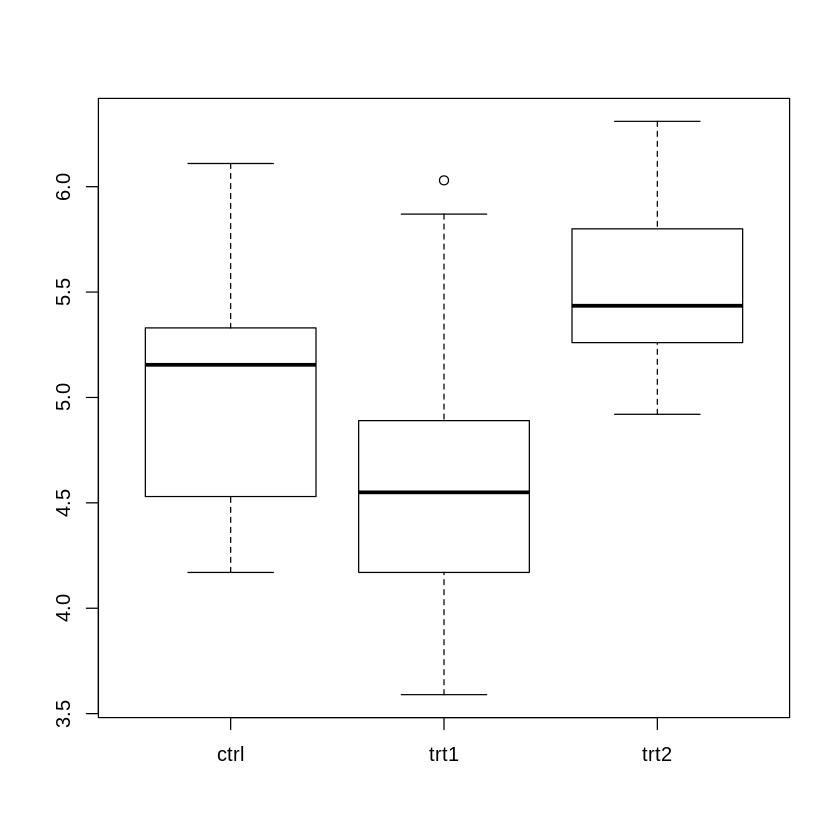

In [5]:
boxplot(weight ~ group, data = PlantGrowth)

Black solid line -- Median

We'll assume each group has the same variance.

## Reference Model with non-informative Prior

In [6]:
ref_lmod = lm(formula = weight ~ group, data = PlantGrowth)

In [7]:
summary(ref_lmod)


Call:
lm(formula = weight ~ group, data = PlantGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4180 -0.0060  0.2627  1.3690 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.0320     0.1971  25.527   <2e-16 ***
grouptrt1    -0.3710     0.2788  -1.331   0.1944    
grouptrt2     0.4940     0.2788   1.772   0.0877 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6234 on 27 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2096 
F-statistic: 4.846 on 2 and 27 DF,  p-value: 0.01591


Above are the posterior mean estimates regarding the three parameters governing the mean.

Intercept - Mean yield for the control group
grouptrt1 - what to add to Intercept to get Mean for treatment group 1.
grouptrt2 - what to add to Intercept to get Mean for treatment group 2.

### ANOVA Table 

In [8]:
anova(ref_lmod)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
group,2,3.76634,1.8831700,4.846088,0.01590996
Residuals,27,10.49209,0.3885959,NA,NA


It indicates the result of a statistical test for each factor variable, whether that factor variable significantly contributes to the variability in the data.

Mean Sq for group -- Variability between the factors

Mean Sq for Residuals -- Variabilty within the factors

## Cell Means Bayesian Model

Each group gets it's own mean

In [25]:
cell_means_mod = "model{
    
    
    #Likelihood
    
    for (i in 1:length(y)){
        
        y[i] ~ dnorm(mu[group[i]], prec)
          
    }
    
    for (i in 1:3){
        
        mu[i] ~ dnorm(0, 1/1e6)
        
    }
    
        #Priors

    prec ~ dgamma(5/2, 5*1/2)
    sigma = sqrt(1/prec)
    
}"

In [12]:
set.seed(42)

In [14]:
str(PlantGrowth)

'data.frame':	30 obs. of  2 variables:
 $ weight: num  4.17 5.58 5.18 6.11 4.5 4.61 5.17 4.53 5.33 5.14 ...
 $ group : Factor w/ 3 levels "ctrl","trt1",..: 1 1 1 1 1 1 1 1 1 1 ...


In [23]:
data_jags = list("y" = PlantGrowth$weight, "group" = as.numeric(PlantGrowth$group))

In [24]:
model_params = c("mu", "sigma")

In [26]:
inits = function(){
    
    inits = list("mu" = rnorm(3,0,100), "prec" = rgamma(1,1,1))
    
}

In [27]:
library(rjags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [28]:
model = jags.model(file = textConnection(cell_means_mod), data = data_jags, inits = inits, n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 4
   Total graph size: 74

Initializing model



In [29]:
update(model, 1e3)

In [30]:
model_sim = coda.samples(model = model, variable.names = model_params, n.iter = 5000)

In [31]:
model_csim = do.call(rbind, model_sim)

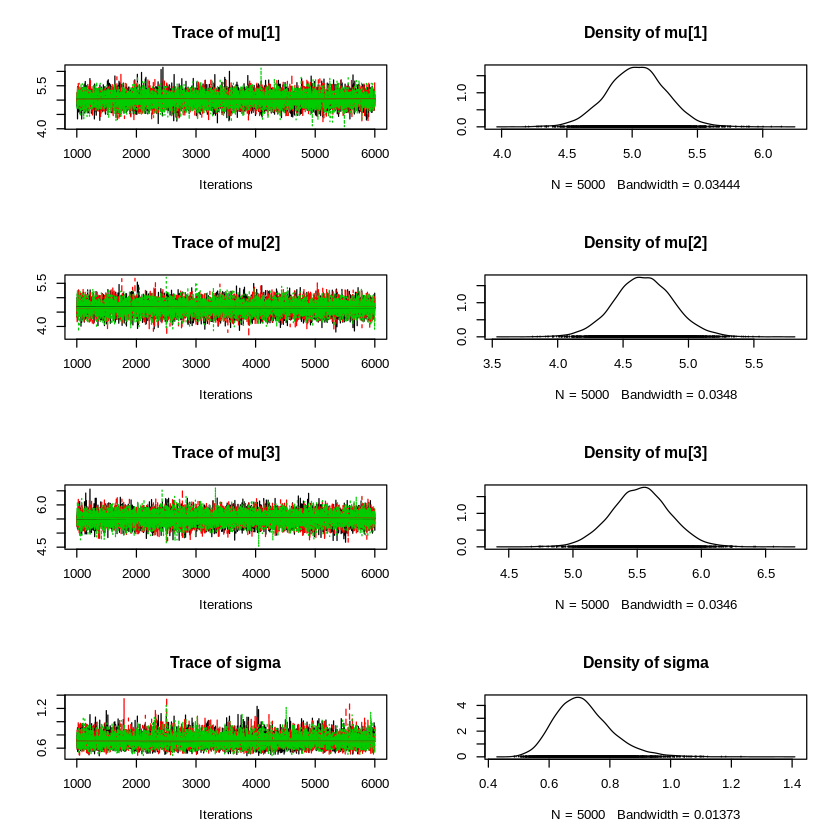

In [32]:
plot(model_sim)

In [33]:
gelman.diag(model_sim)

Potential scale reduction factors:

      Point est. Upper C.I.
mu[1]          1          1
mu[2]          1          1
mu[3]          1          1
sigma          1          1

Multivariate psrf

1

In [34]:
autocorr.diag(model_sim)

,mu[1],mu[2],mu[3],sigma
Lag 0,1.0000000000,1.000000000,1.000000000,1.000000000
Lag 1,0.0082870580,0.012744929,0.002329367,0.112742724
Lag 5,-0.0012757539,-0.006746834,-0.004053336,-0.001889658
Lag 10,0.0002942378,0.011377749,0.002348275,0.009837892
Lag 50,0.0084852523,-0.005960933,-0.014894457,-0.001373366


In [35]:
effectiveSize(model_sim)

mu[1]    mu[2]    mu[3]    sigma 
15000.00 14751.40 15000.00 11959.53

So it has definitely converged.

In [36]:
post_means = colMeans(model_csim)

In [37]:
post_means

mu[1]     mu[2]     mu[3]     sigma 
5.0332574 4.6585210 5.5258057 0.7124895

In [38]:
coefficients(ref_lmod)

(Intercept)   grouptrt1   grouptrt2 
      5.032      -0.371       0.494

This looks very close.

### Residuals

In [39]:
y_pred_mod = post_means[1:3][data_jags$group]

In [40]:
y_pred_mod

mu[1]    mu[1]    mu[1]    mu[1]    mu[1]    mu[1]    mu[1]    mu[1] 
5.033257 5.033257 5.033257 5.033257 5.033257 5.033257 5.033257 5.033257 
   mu[1]    mu[1]    mu[2]    mu[2]    mu[2]    mu[2]    mu[2]    mu[2] 
5.033257 5.033257 4.658521 4.658521 4.658521 4.658521 4.658521 4.658521 
   mu[2]    mu[2]    mu[2]    mu[2]    mu[3]    mu[3]    mu[3]    mu[3] 
4.658521 4.658521 4.658521 4.658521 5.525806 5.525806 5.525806 5.525806 
   mu[3]    mu[3]    mu[3]    mu[3]    mu[3]    mu[3] 
5.525806 5.525806 5.525806 5.525806 5.525806 5.525806

In [41]:
residuals = data_jags$y - y_pred_mod

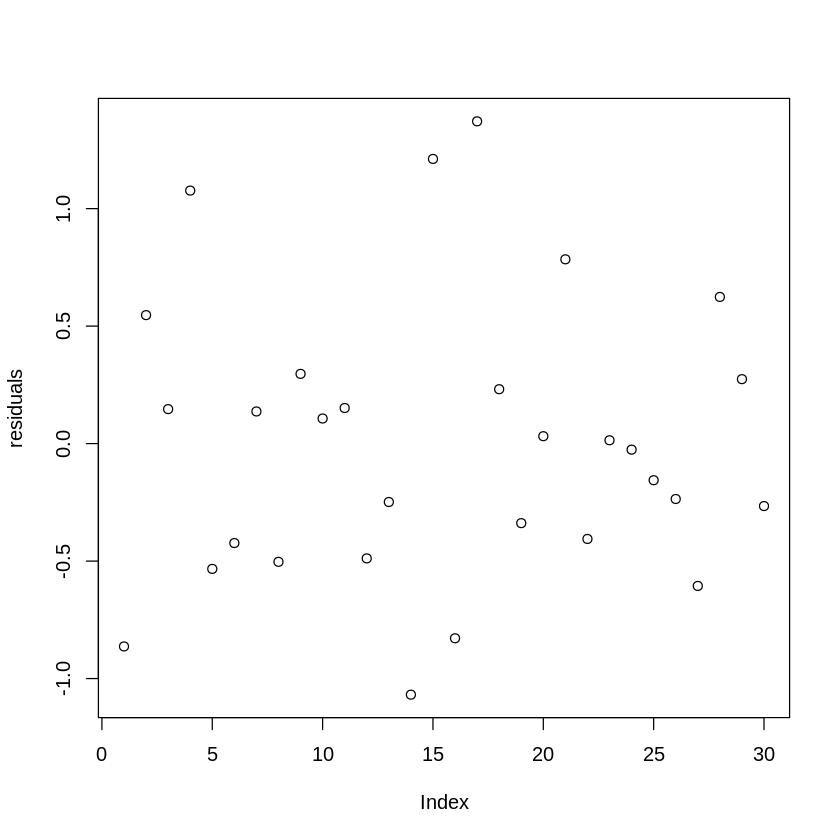

In [43]:
plot(residuals)

No patterns here so it looks good.

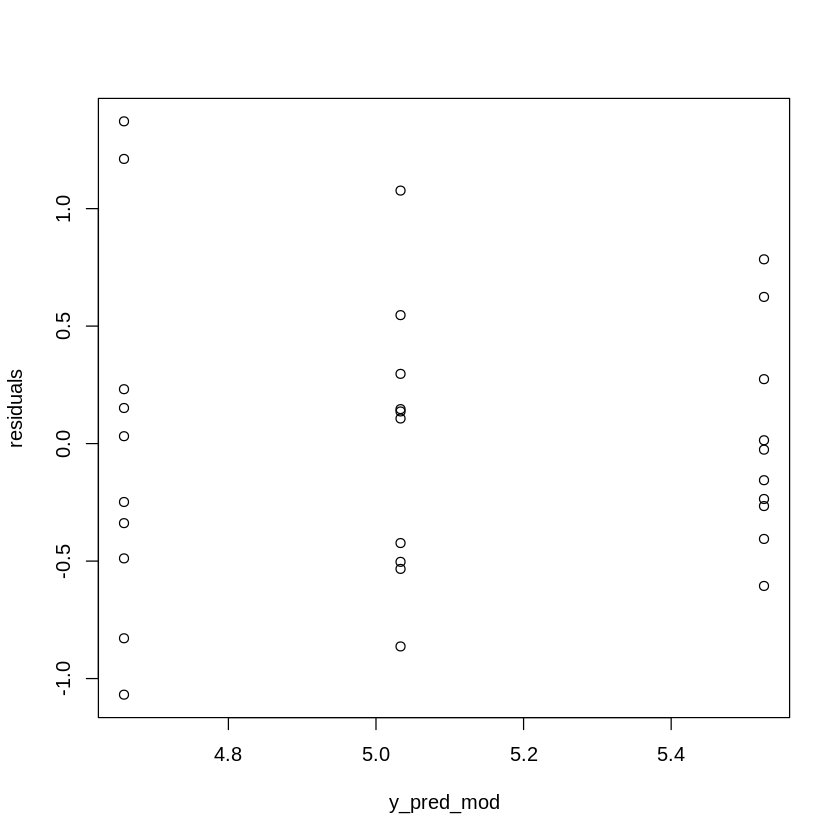

In [44]:
plot(y_pred_mod, residuals)

Note that the Residuals for group 1 seems to have much higher variance than group 3, which could have handled using seperate variance parameters for each group

### Posterior analysis

In [45]:
summary(model_sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
mu[1] 5.0333 0.22655 0.0018498      0.0018498
mu[2] 4.6585 0.22668 0.0018509      0.0018669
mu[3] 5.5258 0.22739 0.0018566      0.0018567
sigma 0.7125 0.09306 0.0007598      0.0008509

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
mu[1] 4.5871 4.8833 5.0340 5.1812 5.4711
mu[2] 4.2148 4.5080 4.6568 4.8089 5.1099
mu[3] 5.0830 5.3762 5.5270 5.6755 5.9707
sigma 0.5594 0.6477 0.7032 0.7664 0.9239


In [47]:
?HPDinterval

HPDinterval {coda},R Documentation
obj,"The object containing the MCMC sample - usually of class ""mcmc"" or ""mcmc.list"""
prob,"A numeric scalar in the interval (0,1) giving the target probability content of the intervals. The nominal probability content of the intervals is the multiple of 1/nrow(obj) nearest to prob."
...,Optional additional arguments for methods. None are used at present.


In [57]:
HPDinterval(model_sim, 0.95)

,lower,upper
mu[1],4.6001974,5.4924596
mu[2],4.2369695,5.1171467
mu[3],5.0603032,5.9552677
sigma,0.5366454,0.8963942
,lower,upper
mu[1],4.5979007,5.4727463
mu[2],4.2093279,5.1103940
mu[3],5.0890943,5.9632761
sigma,0.5487852,0.9054775
,lower,upper


### To find if Treatment 2 yields better results than Control group.

In [59]:
#Indicator variables
mean(model_csim[,3] > model_csim[,1])

[1] 0.9378

#### Probability that mean yield is greater for Treatment group 2 > Control Group is 0.9378, which is a very high probability!!

### Suppose Treatment 2 is costly to put in production, and in order to be worthwhile, this treatment must increase the mean yield by 10%. What's the posterior probability that the increase is atleast that? 

In [61]:
mean(model_csim[,3] > 1.1 * model_csim[,1])

[1] 0.4852

**That is, the probability that the adoption of treatment 2 will increase the yield by 10% is 0.4852**